#Question 1: Denoising Images with Autoencoders

In [ ]:
import pickle

# Function to unpickle CIFAR-10 batch files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

# List of uploaded files
file_paths = [
    "/content/batches.meta",
    "/content/data_batch_1",
    "/content/data_batch_2",
    "/content/data_batch_3",
    "/content/data_batch_4",
    "/content/data_batch_5",
    "/content/test_batch"
]

# Load and display the first batch as an example
data_batch_1 = unpickle(file_paths[1])

# Print keys in the dictionary to explore the data structure
print(data_batch_1.keys())

# Extract images and labels
images = data_batch_1[b'data']
labels = data_batch_1[b'labels']

# Display shape of the data
print(f"Shape of images array: {images.shape}")
print(f"Number of labels: {len(labels)}")

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Shape of images array: (10000, 3072)
Number of labels: 10000


#1️⃣ Load CIFAR-10 and Add Noise

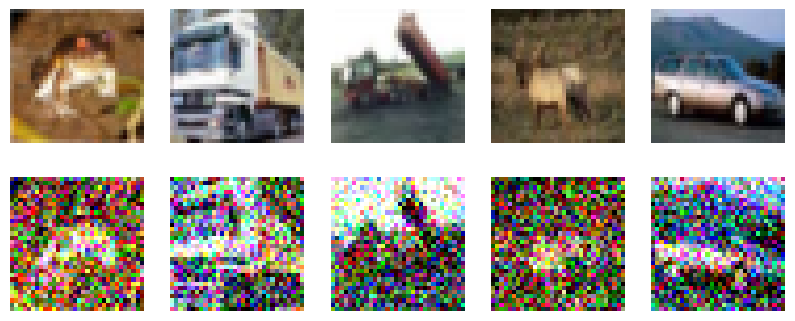

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Normalize to range [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add random noise
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

# Clip values to remain within [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Display original and noisy images
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i])
    plt.axis("off")
plt.show()


#2️⃣ Build the Autoencoder Model

In [ ]:
# Autoencoder Model
input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Model Summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

#3️⃣ Train the Autoencoder

In [ ]:
# Train the model
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.0274 - val_loss: 0.0125
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━

#4️⃣ Test and Visualize the Results

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Get decoded images by using the trained autoencoder to predict on the noisy test set
decoded_imgs = autoencoder.predict(x_test_noisy)

# Calculate Mean Squared Error (MSE)
mse = np.mean((x_test - decoded_imgs) ** 2)
print(f"Mean Squared Error (MSE): {mse:.6f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Mean Squared Error (MSE): 0.007352
